Make a comparison of any two books from the Project Gutenberg portal on the basis of bigrams: plot the 20 most popular bigrams in each of the two books as well as the word networks (choose the cutoff level yourself). Check how the resulting figure looks in the absence of function word removal.

In [16]:
# Books:
# 11 - Alice's Adventures in Wonderland by Lewis Carroll
# 16 - Peter Pan by J. M. Barrie

In [17]:
# importing libraries
import tmtoolkit as tm
from tmtoolkit.corpus import Corpus
import spacy
import statsmodels.formula.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random
from urllib import request


In [18]:
def process_book(name):
    url = "https://www.gutenberg.org/cache/epub/" + name + "/pg" + name + ".txt"
    
    response = request.urlopen(url)
    raw_text = response.read().decode('utf8')
    raw_text=raw_text.split('***')
    raw_text = raw_text[2]  

    file = open('Lab_3_docs/' + name + ".txt", "w", encoding="utf-8")
    file.write(raw_text)
    file.close()



books = [16,11]


for x in books:
    process_book(str(x))

In [19]:
spacy.load('en_core_web_sm')

def prepare_corp(rm_stopwords: bool):
    corp = tm.corpus.Corpus.from_folder("Lab_3_docs", language="en", load_features=[])
    tm.corpus.filter_clean_tokens(corp, remove_stopwords=rm_stopwords)
    tm.corpus.remove_punctuation(corp)
    tm.corpus.to_lowercase(corp)
    tm.corpus.remove_tokens(corp, "")
    tokens = tm.corpus.tokens_table(corp)

    corp_bigrams = tm.corpus.corpus_ngramify(corp, n = 2, inplace=False)
    bigrams = tm.corpus.tokens_table(corp_bigrams)
    return tokens, bigrams

tokens, bigrams = prepare_corp(rm_stopwords = True)
tokens_sw, bigrams_sw = prepare_corp(rm_stopwords = False)
tokens

,doc,position,token,is_punct,is_stop,like_num
0,11,0,illustration,False,False,False
1,11,1,alice,False,False,False
2,11,2,adventures,False,False,False
3,11,3,wonderland,False,False,False
4,11,4,lewis,False,False,False
...,...,...,...,...,...,...
29146,16,18730,children,False,False,False
29147,16,18731,gay,False,False,False
29148,16,18732,innocent,False,False,False
29149,16,18733,heartless,False,False,False


<Axes: xlabel='count', ylabel='token'>

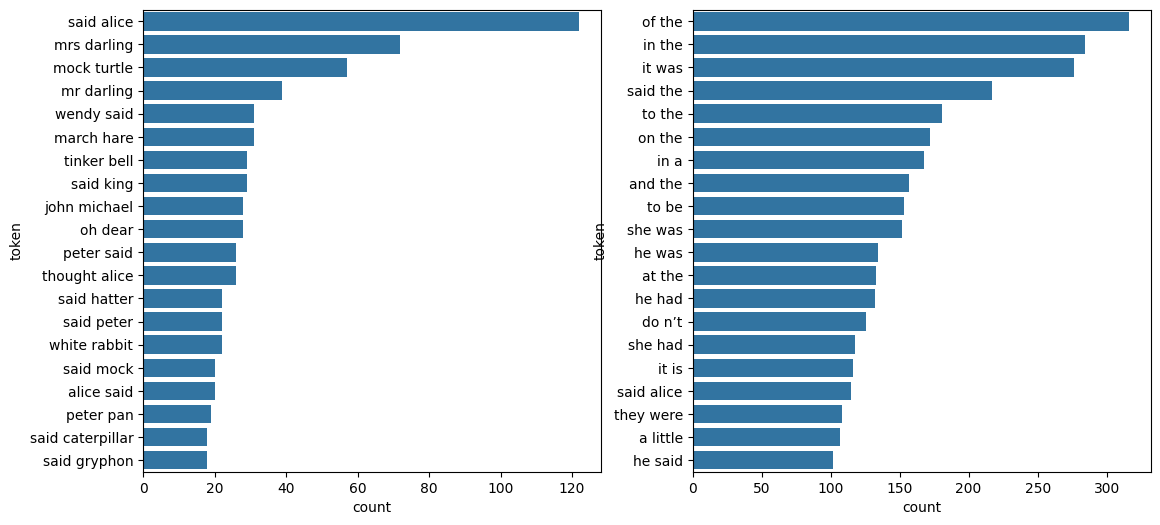

In [20]:
top_bigrams = bigrams["token"].value_counts().reset_index().head(20)
top_bigrams_sw = bigrams_sw["token"].value_counts().reset_index().head(20)

plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
sns.barplot(top_bigrams, y="token", x="count", orient = 'h')

plt.subplot(1,2,2)
sns.barplot(top_bigrams_sw, y="token", x="count", orient = 'h')

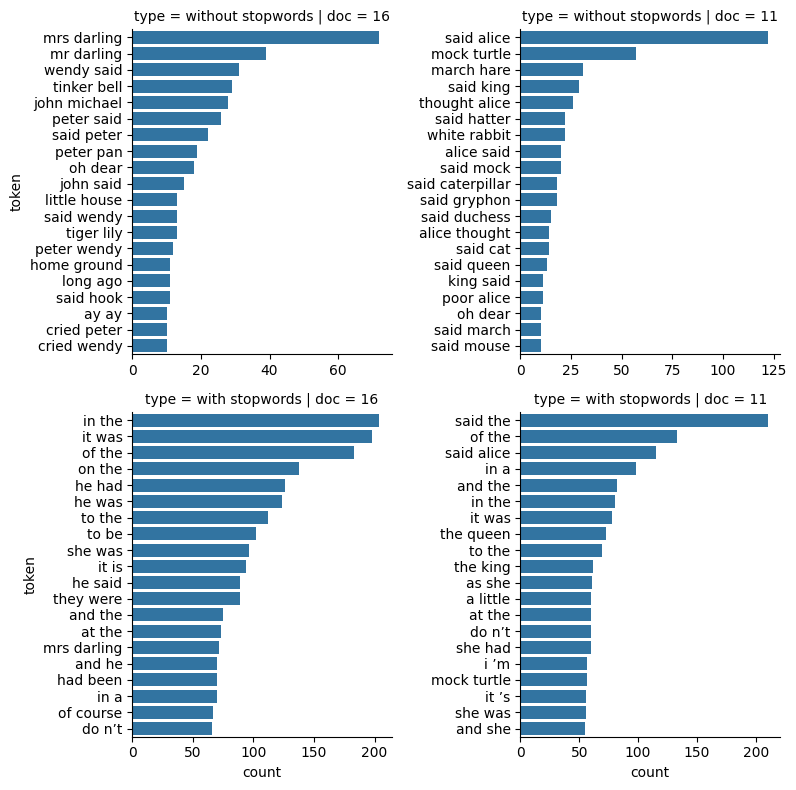

In [ ]:
top_doc_bigrams = bigrams.groupby(["doc", "token"]).size().reset_index(name='count').sort_values(["doc", "count"], ascending=False).groupby("doc").head(20)

top_doc_bigrams_sw = bigrams_sw.groupby(["doc", "token"]).size().reset_index(name='count').sort_values(["doc", "count"], ascending=False).groupby("doc").head(20)

top_doc_bigrams["type"] = "without stopwords"
top_doc_bigrams_sw["type"] = "with stopwords"
top_doc_bigrams = pd.concat([top_doc_bigrams, top_doc_bigrams_sw], ignore_index=True)

g = sns.FacetGrid(top_doc_bigrams, row="type", col="doc", height=4, aspect=1, sharex=False, sharey=False)
g.map_dataframe(sns.barplot, y="token", x="count", orient="h")
plt.show()

# in the version without function words, the word 'said' is very common due to the writing style of the book - statements/dialogues are introduced in this way
# in the version with function words very often there are words like the and be/have conjugated by different persons

In [22]:
df_alice = bigrams[bigrams['doc']=='11']["token"].str.split(expand = True).add_prefix("token")
df_alice = df_alice[["token0", "token1"]].value_counts().reset_index()
df_alice[df_alice.token0 == "said"].head(20)

df_alice_sw = bigrams_sw[bigrams_sw['doc']=='11']["token"].str.split(expand = True).add_prefix("token")
df_alice_sw = df_alice_sw[["token0", "token1"]].value_counts().reset_index()
df_alice_sw[df_alice_sw.token0 == "said"].head(20)

df_peter = bigrams[bigrams['doc']=='16']["token"].str.split(expand = True).add_prefix("token")
df_peter = df_peter[["token0", "token1"]].value_counts().reset_index()
df_peter[df_peter.token0 == "said"].head(20)

df_peter_sw = bigrams_sw[bigrams_sw['doc']=='16']["token"].str.split(expand = True).add_prefix("token")
df_peter_sw = df_peter_sw[["token0", "token1"]].value_counts().reset_index()
df_peter_sw[df_peter_sw.token0 == "said"].head(20)

,token0,token1,count
145,said,peter,22
224,said,and,16
276,said,to,14
411,said,wendy,10
433,said,hook,10
437,said,i,10
515,said,it,9
517,said,slightly,9
541,said,that,8
628,said,john,8


In [27]:
def plotting(df, name, stopwords):
    title = name
    if stopwords == True: 
        title += " with stopwords"
    else: 
        title += " without stopwords"
    plt.figure(figsize=(15,7))
    plt.suptitle(title)
    plt.axis("off")

    plt.subplot(1, 2, 1)
    plt.title('network of words connected to "said"')
    G_ego = nx.from_pandas_edgelist(df[df.token0 == "said"].head(20), "token0", "token1", edge_attr = "count", create_using=nx.DiGraph)
    nx.draw_networkx(G_ego, node_color="lightblue", font_size = 8, font_color = "blue", node_size = 500, width = 0.5*np.sqrt(list(nx.get_edge_attributes(G_ego, 'count').values())))
    plt.axis("off");


    plt.subplot(1, 2, 2)
    plt.title('general network of bigrams')

    G = nx.from_pandas_edgelist(df.head(40), "token0", "token1", edge_attr = "count")
    nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), 
                    node_color="orange", edge_color = "lightgray", font_size = 8, font_color = "blue", node_size = 100, 
                    width = 0.5*np.sqrt(list(nx.get_edge_attributes(G, 'count').values())))
    plt.axis("off");

    plt.show()

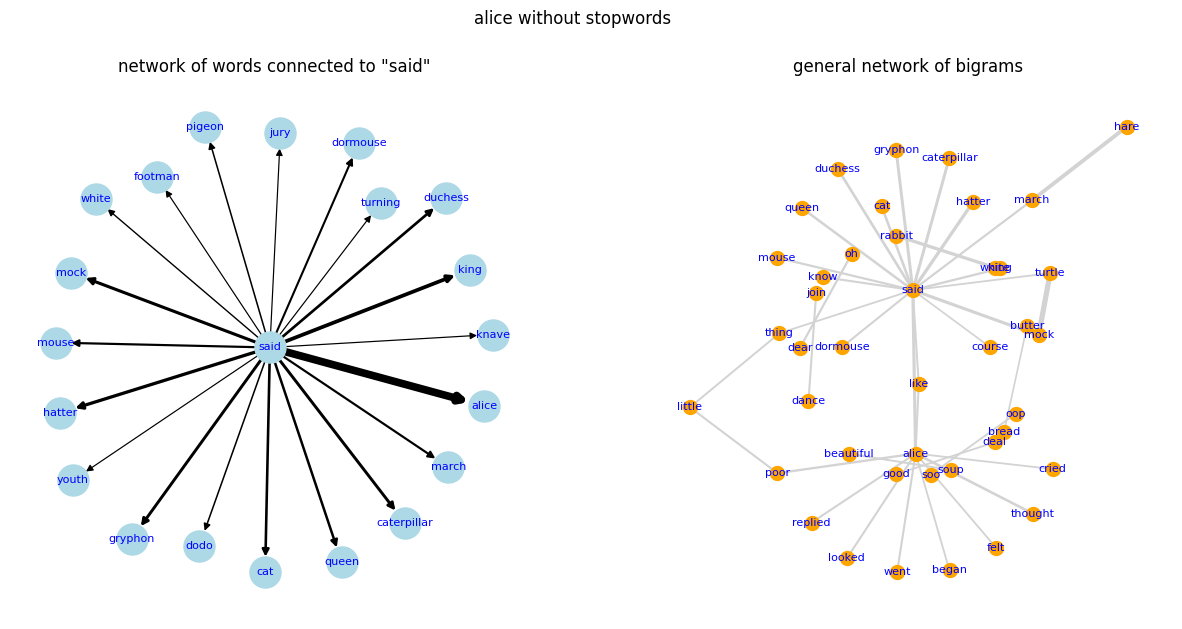

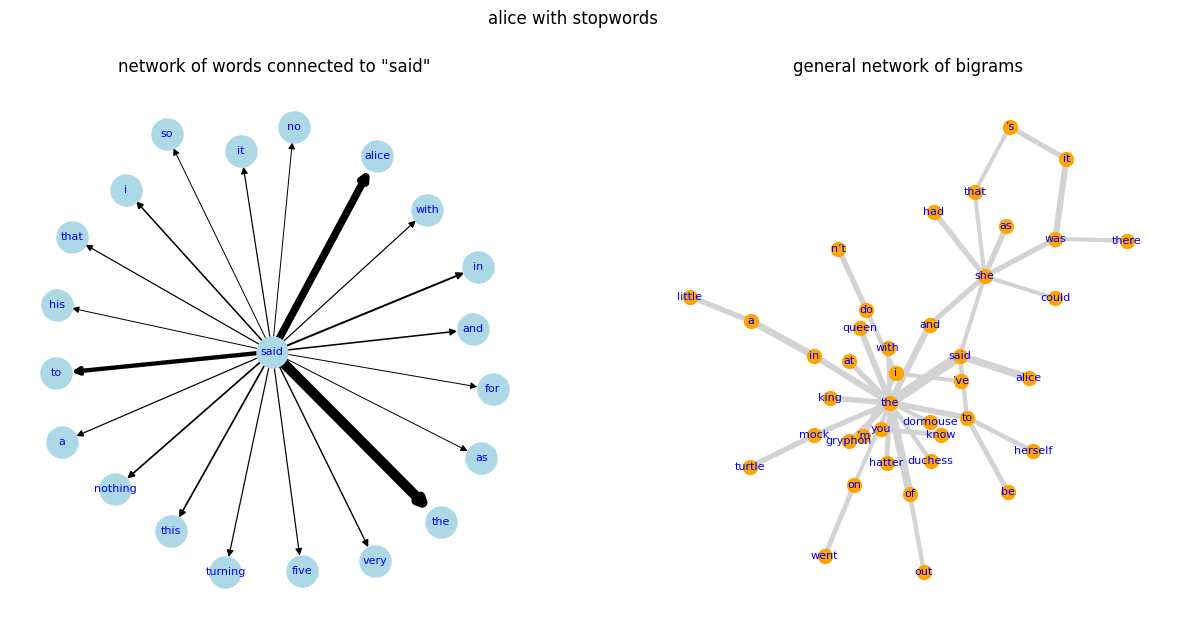

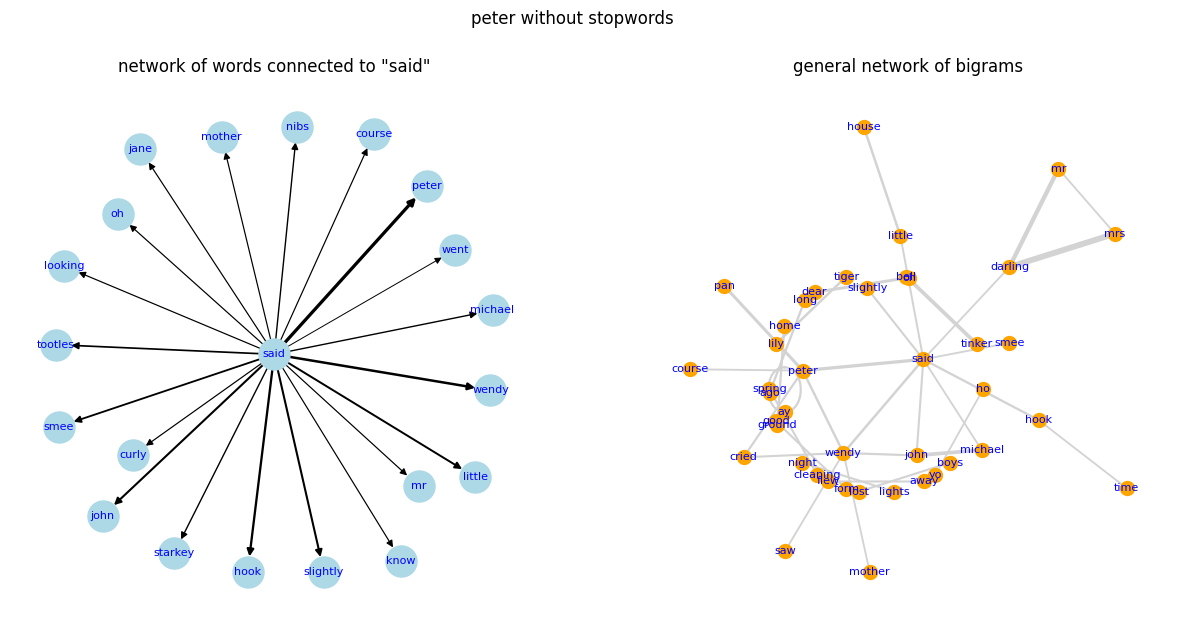

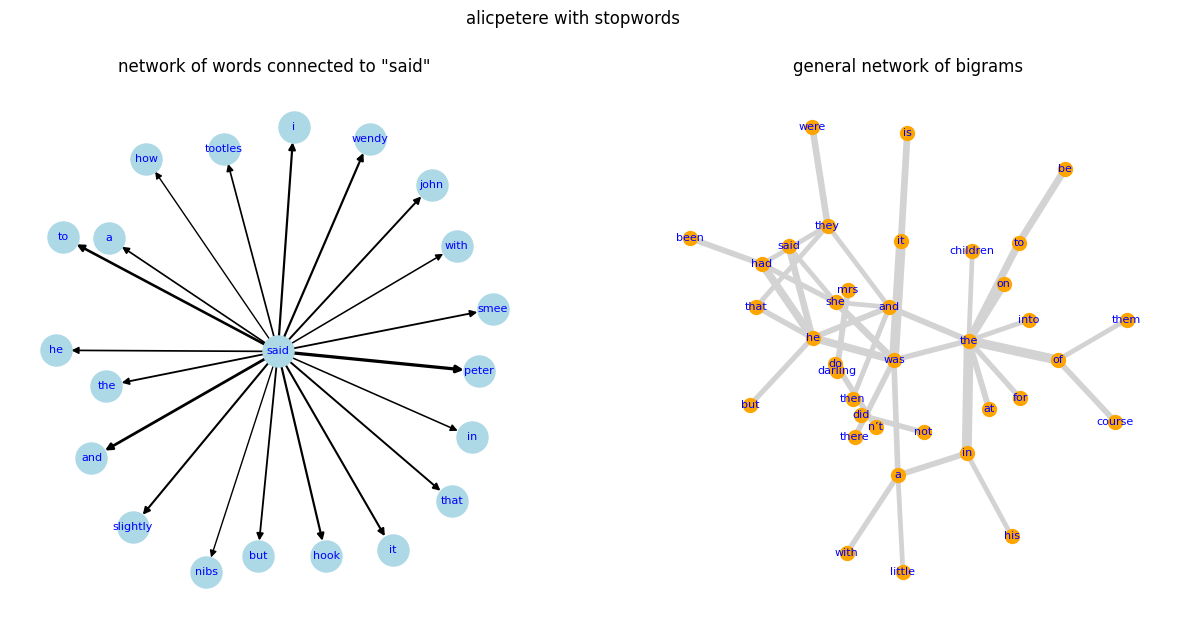

In [28]:
plotting(df_alice, 'alice', False)
plotting(df_alice_sw, 'alice', True)
plotting(df_peter, 'peter', False)
plotting(df_peter_sw, 'alicpetere', True)


# I have plotted networks for said and general bigram networks
# in the version without function words said is usually combined with the characters of the books representing the frequency of the statements of each person
# in the version with function words, only 4 people stood out enough to be in these networks: alice in 1 book and peter, wendy, john in the other. the rest were overshadowed by the aforementioned function words

# in the overall bigram networks, words that could actually give some information about the books are a definite minority